In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.style.use('ggplot')
import seaborn as sns 
sns.set_style('darkgrid')
sns.set(font='SimHei')
path = 'C:/test/work/ppd/data'
import warnings 
warnings.filterwarnings('ignore')

import lightgbm as lgb 
from lightgbm import plot_importance 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
df  = pd.read_csv(path+'/feature_select_data1.csv',encoding='gb18030')
#df.head()

# 两种版本的lgb默认参数模型

## sklearn版本

In [4]:
# 默认参数模型
x_train = df[df.sample_status=='train'].drop(['Idx','sample_status','target'],axis=1)
x_test = df[df.sample_status=='test'].drop(['Idx','sample_status','target'],axis=1)
y_train = df[df.sample_status=='train']['target']
y_test = df[df.sample_status=='test']['target']

In [5]:
import time
start = time.time()
lgb_sklearn = lgb.LGBMClassifier(random_state=0).fit(x_train,y_train)
end = time.time()
print('运行时间为{}秒'.format(round(end-start,0)))

运行时间为4.0秒


0.7415122017542375


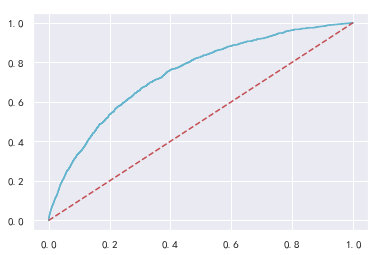

In [12]:
# 默认参数模型的AUC
lgb_sklearn_pre = lgb_sklearn.predict_proba(x_test)[:,1]
print(roc_auc_score(y_test, lgb_sklearn_pre))
fpr,tpr,_=roc_curve(y_test,lgb_sklearn_pre)
plt.plot(fpr, tpr, color = 'c')
plt.plot([0,1],[0,1], color = 'r', linestyle='--')

## 原生版本 

In [13]:
# 原生的lightgbm
lgb_train = lgb.Dataset(x_train,y_train)
lgb_test = lgb.Dataset(x_test,y_test,reference=lgb_train)
lgb_origi_params = {'boosting_type':'gbdt',
              'max_depth':-1,
              'num_leaves':31,
              'bagging_fraction':1.0,
              'feature_fraction':1.0,
              'learning_rate':0.1,
              'metric': 'auc'}
start = time.time()
lgb_origi = lgb.train(train_set=lgb_train,
                      early_stopping_rounds=10,
                      num_boost_round=400,
                      params=lgb_origi_params,
                      valid_sets=lgb_test)
end = time.time()
print('运行时间为{}秒'.format(round(end-start,0)))

[1]	valid_0's auc: 0.648788
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.669304
[3]	valid_0's auc: 0.682628
[4]	valid_0's auc: 0.686994
[5]	valid_0's auc: 0.691935
[6]	valid_0's auc: 0.695382
[7]	valid_0's auc: 0.695489
[8]	valid_0's auc: 0.698546
[9]	valid_0's auc: 0.701733
[10]	valid_0's auc: 0.70455
[11]	valid_0's auc: 0.70806
[12]	valid_0's auc: 0.712569
[13]	valid_0's auc: 0.714239
[14]	valid_0's auc: 0.716405
[15]	valid_0's auc: 0.716735
[16]	valid_0's auc: 0.719263
[17]	valid_0's auc: 0.72103
[18]	valid_0's auc: 0.723517
[19]	valid_0's auc: 0.725592
[20]	valid_0's auc: 0.727763
[21]	valid_0's auc: 0.727528
[22]	valid_0's auc: 0.728322
[23]	valid_0's auc: 0.730293
[24]	valid_0's auc: 0.730048
[25]	valid_0's auc: 0.730812
[26]	valid_0's auc: 0.730772
[27]	valid_0's auc: 0.731304
[28]	valid_0's auc: 0.731212
[29]	valid_0's auc: 0.73119
[30]	valid_0's auc: 0.732287
[31]	valid_0's auc: 0.732734
[32]	valid_0's auc: 0.7329
[33]	valid_0's auc: 0.733

0.7381553168735197


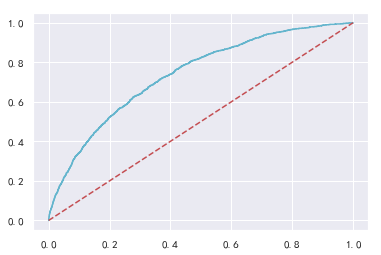

In [14]:
# 原生的lightgbm的AUC
lgb_origi_pre = lgb_origi.predict(x_test)
print(roc_auc_score(y_test, lgb_origi_pre))
fpr,tpr,_=roc_curve(y_test,lgb_origi_pre)
plt.plot(fpr, tpr, color = 'c')
plt.plot([0,1],[0,1], color = 'r', linestyle='--')

# 调参

In [15]:
# 确定最大迭代次数，学习率设为0.1 
base_parmas={'boosting_type':'gbdt', 'learning_rate':0.1, 'num_leaves':40,'max_depth':-1,
             'bagging_fraction':0.8, 'feature_fraction':0.8, 'lambda_l1':0,'lambda_l2':0,
             'min_data_in_leaf':20,'min_sum_hessian_inleaf':0.001,'metric':'auc'}
cv_result = lgb.cv(train_set=lgb_train, num_boost_round=200,early_stopping_rounds=5,
                nfold=5,stratified=True,shuffle=True,params=base_parmas,metrics='auc',seed=0)

In [16]:
print('最大的迭代次数: {}'.format(len(cv_result['auc-mean'])))
print('交叉验证的AUC: {}'.format(max(cv_result['auc-mean'])))

最大的迭代次数: 56
交叉验证的AUC: 0.7212960286019683


In [17]:
# num_leaves ，步长设为5
param_find1 = {'num_leaves':range(30,60,5)}
cv_fold = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
start = time.time()
grid_search1 = GridSearchCV(estimator=lgb.LGBMClassifier(learning_rate=0.1,n_estimators = 56,
                    max_depth=-1,min_child_weight=0.001,min_child_samples=20,subsample=0.8,
                    colsample_bytree=0.8,reg_lambda=0, reg_alpha=0),cv = cv_fold,
                             n_jobs=-1,param_grid = param_find1,scoring='roc_auc')
grid_search1.fit(x_train,y_train)
end = time.time()
print('运行时间为:{}'.format(round(end-start,0)))

运行时间为:61.0


In [19]:
print(grid_search1.best_params_)
print('\t')
print(grid_search1.best_score_)

{'num_leaves': 30}
	
0.7300330243340516


In [20]:
# num_leaves,步长设为2 
param_find2 = {'num_leaves':range(26,34,2)}
grid_search2 = GridSearchCV(estimator=lgb.LGBMClassifier(estimator=56,
                                                         learning_rate=0.1,
                                                         min_child_weight=0.001,
                                                         min_child_samples=20,
                                                         subsample=0.8,
                                                         colsample_bytree=0.8,
                                                         reg_lambda=0,
                                                         reg_alpha=0),
                            cv=cv_fold,
                            n_jobs=-1,
                            scoring='roc_auc',
                            param_grid = param_find2)
grid_search2.fit(x_train,y_train)
print(grid_search2.best_params_)
print('\t')
print(grid_search2.best_score_)

{'num_leaves': 30}
	
0.7323918882243231


In [21]:
# 确定num_leaves 为30 ，下面进行min_child_samples 和 min_child_weight的调参，设定步长为5
param_find3 = {'min_child_samples':range(15,35,5),
               'min_child_weight':[x/1000 for x in range(1,4,1)]}
grid_search3 = GridSearchCV(estimator=lgb.LGBMClassifier(estimator=56,
                                                         learning_rate=0.1,
                                                         num_leaves=30,
                                                         subsample=0.8,
                                                         colsample_bytree=0.8,
                                                         reg_lambda=0,
                                                         reg_alpha=0),
                            cv=cv_fold,
                            scoring='roc_auc',
                            param_grid = param_find3,
                            n_jobs=-1)
start = time.time()
grid_search3.fit(x_train,y_train)
end = time.time()
print('运行时间:{} 秒'.format(round(end-start,0)))
print(grid_search3.best_params_)
print('\t')
print(grid_search3.best_score_)

运行时间:143.0 秒
{'min_child_samples': 30, 'min_child_weight': 0.001}
	
0.7356868012059826


In [22]:
# 确定min_child_weight为0.001，min_child_samples为20,下面对subsample和colsample_bytree进行调参
param_find4 = {'subsample':[x/10 for x in range(5,10,1)],
               'colsample_bytree':[x/10 for x in range(5,10,1)]}
grid_search4 = GridSearchCV(estimator=lgb.LGBMClassifier(estimator=56, learning_rate=0.1,
                            min_child_samples=30,min_child_weight=0.001,num_leaves=30,subsample=0.8,
                            colsample_bytree=0.8, reg_lambda=0,reg_alpha=0),cv=cv_fold,
                            scoring='roc_auc',param_grid = param_find4, n_jobs=-1)
start = time.time()
grid_search4.fit(x_train,y_train)
end = time.time()
print('运行时间:{} 秒'.format(round(end-start,0)))
print(grid_search4.best_params_)
print('\t')
print(grid_search4.best_score_)

运行时间:270.0 秒
{'colsample_bytree': 0.9, 'subsample': 0.5}
	
0.7371037061045744


In [23]:
param_find5 = {'reg_lambda':[0.001,0.01,0.03,0.08,0.1,0.3],
               'reg_alpha':[0.001,0.01,0.03,0.08,0.1,0.3]}
grid_search5 = GridSearchCV(estimator=lgb.LGBMClassifier(estimator=56,learning_rate=0.1,
                        min_child_samples=30,min_child_weight=0.001,num_leaves=30,subsample=0.5,
                        colsample_bytree=0.9,), cv=cv_fold, scoring='roc_auc',
                            param_grid = param_find5, n_jobs=-1)
start = time.time()
grid_search5.fit(x_train,y_train)
end = time.time()
print('运行时间:{} 秒'.format(round(end-start,0)))
print(grid_search5.best_params_)
print('\t')
print(grid_search5.best_score_)

运行时间:403.0 秒
{'reg_alpha': 0.03, 'reg_lambda': 0.001}
	
0.7408715839786831


In [24]:
# 将最佳参数再次带入cv函数，设定学习率为0.005
best_params = { 'boosting_type':'gbdt','learning_rate':0.005,'num_leaves':30,'max_depth':-1,
    'bagging_fraction':0.5,'feature_fraction':0.9,'min_data_in_leaf':30, 'min_sum_hessian_in_leaf':0.001,
    'lambda_l1':0.03,'lambda_l2':0.001,'metric':'auc'}

best_cv = lgb.cv(train_set=lgb_train,early_stopping_rounds=5, num_boost_round=2000,nfold=5,
                 params=best_params,metrics='auc', stratified=True, shuffle=True,seed=0)

In [25]:
print('最佳参数的迭代次数: {}'.format(len(best_cv['auc-mean'])))
print('交叉验证的AUC: {}'.format(max(best_cv['auc-mean'])))

最佳参数的迭代次数: 952
交叉验证的AUC: 0.7374010697216228


In [26]:
lgb_single_model = lgb.LGBMClassifier(n_estimators=952, learning_rate=0.005, min_child_weight=0.001,
                                min_child_samples = 30,subsample=0.5,colsample_bytree=0.9,
                        num_leaves=30,max_depth=-1,reg_lambda=0.001,reg_alpha=0.03,random_state=0)
lgb_single_model.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.005, max_depth=-1,
               min_child_samples=30, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=952, n_jobs=-1, num_leaves=30, objective=None,
               random_state=0, reg_alpha=0.03, reg_lambda=0.001, silent=True,
               subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

lightgbm单模型的AUC：0.7523800823152327


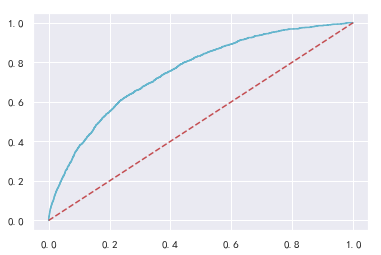

In [27]:
pre = lgb_single_model.predict_proba(x_test)[:,1]
print('lightgbm单模型的AUC：{}'.format(metrics.roc_auc_score(y_test,pre)))
fpr,tpr,_=roc_curve(y_test,pre)
plt.plot(fpr, tpr, color = 'c')
plt.plot([0,1],[0,1], color = 'r', linestyle='--')